# creek fire
- Ted has 19 utc 5th - 1 utc 6th : just use sept 5

## import packages 

In [1]:
# import all packages that are needed 

import numpy as np
from datetime import datetime
import metpy  # noqa: F401
import xarray
import pandas as pd
import os
from textwrap import wrap
import seaborn as sns
import awscli as aws
import scipy.stats as ss 

#cartopy 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# matplotlib
from pymatreader import read_mat
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as grd
from mpl_toolkits.axes_grid1 import ImageGrid

# animation 
from celluloid import Camera
from IPython.display import HTML
import ffmpeg
from matplotlib import animation, rc
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from shapely import geometry
from IPython.display import HTML

## import data

In [2]:
A = read_mat('/data/edworak/2020-09-05-Bortnik.mat')
df_a = pd.DataFrame(A['Events'], columns = ["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "j",  "k", "l", "m"])
sept5_og = df_a.loc[:, ~df_a.columns.isin(["j",  "k", "l", "m"])]

sept5 = pd.DataFrame(sept5_og)
polarity = []
for i in range(len(sept5_og)): 
    if sept5["peak-current"][i] > 0:
           polarity.append("+")
    elif sept5["peak-current"][i] < 0:
           polarity.append("-")
sept5['polarity'] = polarity

B = read_mat('/data/edworak/2020-09-06-Bortnik.mat')
df_b = pd.DataFrame(B['Events'], columns = ["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "j",  "k", "l", "m"])
sept6_og = df_b.loc[:, ~df_b.columns.isin(["j",  "k", "l", "m"])]

sept6 = pd.DataFrame(sept6_og)
polarity = []
for i in range(len(sept6_og)): 
    if sept6["peak-current"][i] > 0:
           polarity.append("+")
    elif sept6["peak-current"][i] < 0:
           polarity.append("-")
sept6['polarity'] = polarity


In [3]:
frames = [sept5, sept6]
data_concat = pd.concat(frames)
# sept5 is hours 21 to 22: 21, 22
# sept6 is hours 11 to 21: 11, 12, 14, 16, 21
data_concat

,year,month,day,hour,minute,second,lat,lon,peak-current,polarity
0,2020.0,9.0,5.0,21.0,16.0,8.161140,37.390300,-119.469407,-2.0,-
1,2020.0,9.0,5.0,21.0,16.0,8.191126,37.383592,-119.470595,-5.0,-
2,2020.0,9.0,5.0,21.0,24.0,52.673364,37.422026,-119.476456,3.0,+
3,2020.0,9.0,5.0,21.0,30.0,26.391983,37.398544,-119.335330,-6.0,-
4,2020.0,9.0,5.0,21.0,30.0,26.392564,37.380539,-119.361831,-31.0,-
...,...,...,...,...,...,...,...,...,...,...
28,2020.0,9.0,6.0,16.0,15.0,27.280823,37.277400,-119.381270,-7.0,-
29,2020.0,9.0,6.0,16.0,16.0,12.473359,37.287164,-119.425748,6.0,+
30,2020.0,9.0,6.0,16.0,18.0,47.061373,37.276833,-119.387281,-6.0,-
31,2020.0,9.0,6.0,21.0,15.0,31.847667,37.157943,-119.253819,7.0,+


## functions

In [4]:
days = [5, 6]
hours1 = range(0, 24, 1)
#hours1 = [21, 22, 11, 12, 14, 16, 21]
mins = range(0, 60, 10)


empty_hours = []
empty_strikes = []
all_strikes_flat = []

strike_array = []
strike_pos_array = []
strike_neg_array = []

num_strikes = np.zeros((len(days), len(hours1), len(mins)))
mean_current = np.zeros((len(days), len(hours1), len(mins)))
mean_pos_current = np.zeros((len(days), len(hours1), len(mins)))
mean_neg_current = np.zeros((len(days), len(hours1), len(mins)))
percent_pos_current = np.zeros((len(days), len(hours1), len(mins)))
num_pos_current =  np.zeros((len(days), len(hours1), len(mins)))
num_neg_current =  np.zeros((len(days), len(hours1), len(mins)))


def alldays_function(df):
    for d in range(len(days)): 
        for i in range(len(hours1)): 
            for j in range(len(mins)):  

                # (df.day == days[d]) &
                strikes = df.loc[(df["day"] == days[d]) & (df["hour"] == hours1[i]) & (df.minute >= mins[j]) & (df.minute <= mins[j] + 9) & (df.lon >= -120) & (df.lon <= -119) & (df.lat >= 37) & (df.lat <= 38)]

                if len(strikes) >= 1: 

                    # this will give us flat arrays for all strikes, hours array will show time stamps                        
                    all_strikes = np.append(empty_strikes, strikes["peak-current"])
                    hours = np.append(empty_hours, strikes["hour"], axis = 0)
                    num_strikes[d,i,j] = len(strikes)
                    mean_current[d,i,j] = np.mean(abs(strikes["peak-current"]))

                    pos_current = strikes.loc[(strikes["peak-current"] > 0)]
                    num_pos_current[d,i,j]= len(pos_current)
                    mean_pos_current[d,i,j] = pos_current["peak-current"].mean()

                    neg_current = strikes.loc[(strikes["peak-current"] < 0)]
                    num_neg_current[d,i,j] = len(neg_current)

                    mean_neg_current[d,i,j] = neg_current["peak-current"].mean()

                    strike_array.append(np.array(strikes["peak-current"]))
                    strike_pos_array.append(np.array(strikes[(strikes["peak-current"] > 0)]["peak-current"]))
                    strike_neg_array.append(np.array(strikes[(strikes["peak-current"] < 0)]["peak-current"]))

                    if len(strikes)> 2: 
                        percent_pos_current[d,i,j] = (len(pos_current["peak-current"]) / len(strikes)) * 100

    return(num_strikes, percent_pos_current, num_pos_current, num_neg_current, 
            mean_current, mean_pos_current, mean_neg_current, all_strikes, hours, strike_array, strike_pos_array, strike_neg_array)



In [15]:
# alldays_function(data_concat)[0]

In [33]:
d = {}

names = ["num_strikes", "percent_pos_current", "num_pos_current", "num_neg_current", 
            "mean_current", "mean_pos_current", "mean_neg_current"]

for i in range(0, len(names)):
    a = alldays_function(data_concat)[i]
    b = [item for sublist in a for item in sublist]
    c = [item for sublist in b for item in sublist]
    d[names[i]] = c
#     data = {[alldays_function(data_concat)[0]], 
#            [alldays_function(data_concat)[1]], 
#            [alldays_function(data_concat)[2]], 
#            [alldays_function(data_concat)[3]]}
    #df = pd.DataFrame(c, columns=[names[0]])
    #df['Hour']=[np.arange(0, len(c))]
    # if i == 0: 
    df1['Num Strikes']= c
#     if i == 1: 
#         df['Percent Pos Current']=[c]
#     if i == 2: 
#         df['Num Pos Strikes']=[c]
#     if i == 3: 
#         df['Num Neg Strikes']=[c]

#d["num_strikes"][127:-16]
#df.to_csv('data.csv')
df1

,num_strikes,Num Strikes
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
283,0.0,0.0
284,0.0,0.0
285,0.0,0.0
286,0.0,0.0


In [25]:
df=open('text file','w')
df.write('We will be seeing an interated printing of numbers between 0 to 10\n')

for i in range(0,11):
    df.write(str(i))
    df.write('\n')
df.close()



## sept 5 flat arrays

In [7]:
# days = [5, 6]
#hours = range(0, 23, 1)

hours = [21, 22]
mins = range(0, 60, 10)

strike_array = []
strike_mag_array = []
strike_pos_array = []
strike_neg_array = []

# for d in range(len(days)):
for i in range(len(hours)): 
    for j in range(len(mins)): 
        points = sept5[(sept5["hour"] == hours[i]) & (sept5["minute"] >= mins[j]) & (sept5["minute"] <= mins[j] + 9) & (sept5["lon"] >= -120) & (sept5["lon"] <= -119) & (sept5["lat"] >= 37) & (sept5["lat"] <= 38)]
        strike_array.append(np.array(points["peak-current"]))
        strike_mag_array.append(abs(np.array(points["peak-current"])))
        strike_pos_array.append(np.array(points[(points["peak-current"] > 0)]["peak-current"]))
        strike_neg_array.append(np.array(points[(points["peak-current"] < 0)]["peak-current"]))

strike_array_flat = [item for sublist in strike_array for item in sublist]
strike_mag_array_flat = [item for sublist in strike_mag_array for item in sublist]
strike_pos_array_flat = [item for sublist in strike_pos_array for item in sublist] 
strike_neg_array_flat = [item for sublist in strike_neg_array for item in sublist] 

In [8]:
print(np.mean(strike_array_flat))
print(np.mean(strike_mag_array_flat))
print(np.mean(strike_pos_array_flat))
print(np.mean(strike_neg_array_flat))


-4.345454545454546
8.49090909090909
9.5
-8.209302325581396


## map

In [9]:
def subregion_box(ax, subregion):
    geom = geometry.box(minx=-120,maxx=-119,miny=37,maxy=38)
    ax.add_geometries([geom], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='black',)
    return ax
len(data_concat.loc[(data_concat.lon > -120) & (data_concat.lon < -119) & (data_concat.lat > 37) & (data_concat.lat < 38)])



88

/home/elenadworak/anaconda3/envs/mynewenv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/elenadworak/anaconda3/envs/mynewenv/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/elenadworak/anaconda3/envs/mynewenv/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


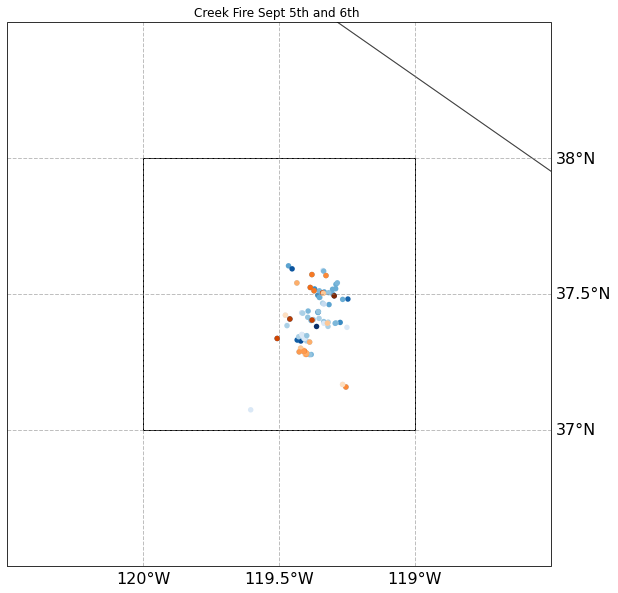

In [10]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")


# Make figure larger
plt.xlim([-120.5, -118.5])
plt.ylim([36.5, 38.5])


points_pos = data_concat.loc[(data_concat.lon > -121) & (data_concat.lon < -117) & (data_concat.lat > 36) & (data_concat.lat < 39)]
points_neg = data_concat.loc[(data_concat.lon > -121) & (data_concat.lon < -117) & (data_concat.lat > 36) & (data_concat.lat < 39)]
subregion_box(ax, points_pos)

#negative polarity 
plt.scatter(x = points_neg["lon"], y = points_neg["lat"], c = np.log(abs(points_neg["peak-current"])), cmap="Blues", s = 30, edgecolors="none", marker = 'o', alpha=1)
#positive polarity
plt.scatter(x = points_pos["lon"], y = points_pos["lat"], c = np.log(points_pos["peak-current"]), cmap="Oranges", s = 30, edgecolors="none", marker = 'o', alpha=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-121, -120.5, -120, -119.5, -119, -118.5, -118, -117.5])
gl.ylocator = mticker.FixedLocator([ 36,  36.5,  37,  37.5,  38,  38.5])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

plt.title("Creek Fire Sept 5th and 6th ")
plt.savefig("creek_fire_map", dpi = 200)

plt.show()

## large map

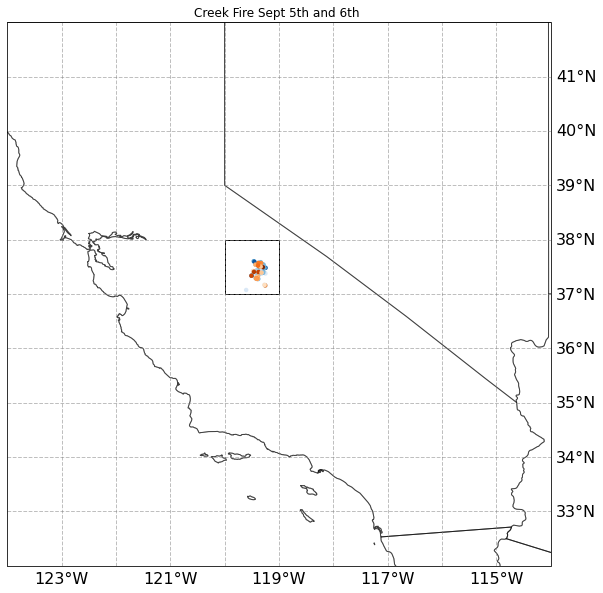

In [11]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")


# Make figure larger
plt.xlim([-124, -114])
plt.ylim([32, 42])


points_pos = data_concat.loc[(data_concat.lon > -124) & (data_concat.lon < -114) & (data_concat.lat > 32) & (data_concat.lat < 42)]
points_neg = data_concat.loc[(data_concat.lon > -124) & (data_concat.lon < -114) & (data_concat.lat > 32) & (data_concat.lat < 42)]
subregion_box(ax, points_pos)

#negative polarity 
plt.scatter(x = points_neg["lon"], y = points_neg["lat"], c = np.log(abs(points_neg["peak-current"])), cmap="Blues", s = 20, edgecolors="none", marker = 'o', alpha=1)
#positive polarity
plt.scatter(x = points_pos["lon"], y = points_pos["lat"], c = np.log(points_pos["peak-current"]), cmap="Oranges", s = 20, edgecolors="none", marker = 'o', alpha=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -123, -122, -121, -120, -119, -118, -117, -116, -115])
gl.ylocator = mticker.FixedLocator([ 32, 33, 34, 35, 36,  37, 38, 39, 40, 41])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

plt.title("Creek Fire Sept 5th and 6th ")
plt.savefig("creek_fire_map", dpi = 200)

plt.show()

## time series 

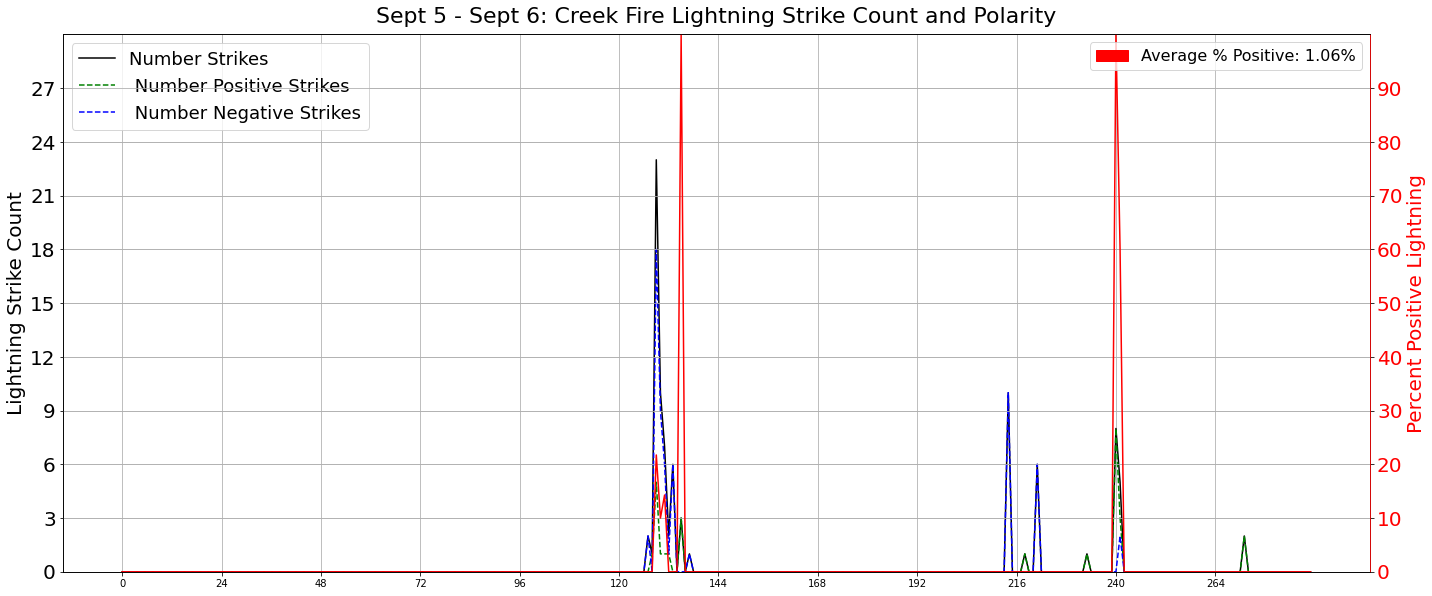

In [12]:
fig,ax = plt.subplots(figsize=(20,8))

xValues = np.arange(0, 288, 1)
xticks = np.arange(0, 288, 24)
yticks = np.arange(0, 30, 3)

ax.plot(xValues, d["num_strikes"], "k-", label = "Number Strikes")
ax.plot(xValues, d["num_pos_current"], "g--", label = " Number Positive Strikes")
ax.plot(xValues, d["num_neg_current"], "b--", label = " Number Negative Strikes")

ax.set_ylim((0,30))
ax.set_ylabel("Lightning Strike Count", fontsize = 20)
ax.legend(loc = "upper left", fontsize = 18)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
# labels = ["06/29 8 UTC", "06/29 9 UTC", "06/29 10 UTC", "06/29 11 UTC", "06/29 12 UTC"]
# labels = ['\n'.join(wrap(l, 6)) for l in labels]
# ax.set_xticklabels(labels, fontsize = 20)
ax.set_yticklabels(yticks, fontsize = 20)
plt.grid()

yticks2 = np.arange(0, 100, 10)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(xValues, d["percent_pos_current"], color="red")
ax2.set_ylabel("Percent Positive Lightning", color="red",fontsize=20)
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2, fontsize = 20,  color="red")
ax2.set_ylim((0,100))
ax2.spines['right'].set_color('red')


red_patch = mpatches.Patch(color='red', label='Average % Positive: {:.2f}%'.format(np.mean(d["percent_pos_current"])))
plt.legend(handles=[red_patch], fontsize = 16, loc = "upper right")

plt.grid()
plt.tight_layout()
plt.title("Sept 5 - Sept 6: Creek Fire Lightning Strike Count and Polarity", y=1.01, fontsize = 22) 
plt.savefig("creekfire_long_timeseries.png", bbox_inches = "tight", dpi = 500)

# short timeseries

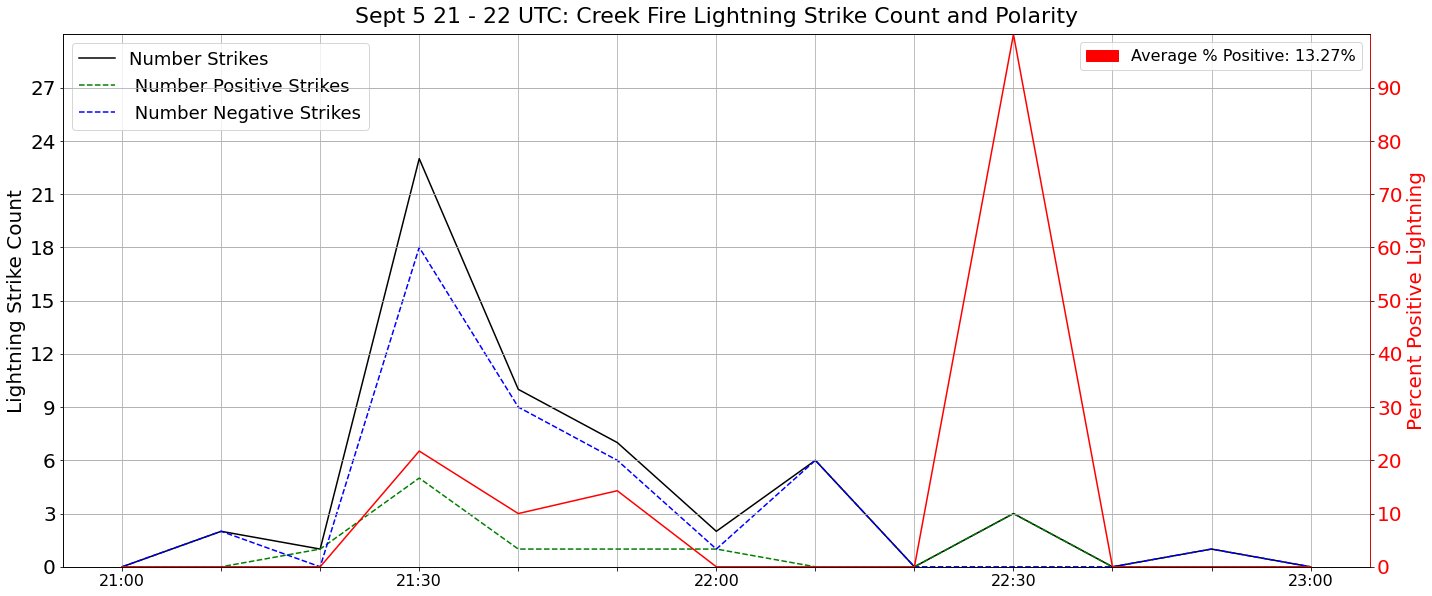

In [13]:
fig,ax = plt.subplots(figsize=(20,8))

xValues = np.arange(0, 13, 1)
xticks = np.arange(0, 13, 1)
yticks = np.arange(0, 30, 3)

ax.plot(xValues, d["num_strikes"][126: 139], "k-", label = "Number Strikes")

ax.plot(xValues, d["num_pos_current"][126: 139], "g--", label = " Number Positive Strikes")
ax.plot(xValues, d["num_neg_current"][126: 139], "b--", label = " Number Negative Strikes")

ax.set_ylim((0,30))
ax.set_ylabel("Lightning Strike Count", fontsize = 20)
ax.legend(loc = "upper left", fontsize = 18)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
# labels = ["06/29 8 UTC", "06/29 9 UTC", "06/29 10 UTC", "06/29 11 UTC", "06/29 12 UTC"]
# labels = ['\n'.join(wrap(l, 6)) for l in labels]
# ax.set_xticklabels(labels, fontsize = 20)
ax.set_yticklabels(yticks, fontsize = 20)
plt.grid()

yticks2 = np.arange(0, 100, 10)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(xValues, d["percent_pos_current"][126: 139], color="red")
ax2.set_ylabel("Percent Positive Lightning", color="red",fontsize=20)
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2, fontsize = 20,  color="red")
ax2.set_ylim((0,100))
ax2.spines['right'].set_color('red')

labels = ["21:00",  "", "", "21:30", "", "",
          "22:00",  "", "", "22:30", "", "", "23:00"]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)

red_patch = mpatches.Patch(color='red', label='Average % Positive: {:.2f}%'.format(np.mean(d["percent_pos_current"][127: 138])))
plt.legend(handles=[red_patch], fontsize = 16, loc = "upper right")

plt.grid()
plt.tight_layout()
plt.title("Sept 5 21 - 22 UTC: Creek Fire Lightning Strike Count and Polarity", y=1.01, fontsize = 22) 
plt.savefig("creekfire_short_timeseries.png", bbox_inches = "tight", dpi = 500)

## creating data frame

In [14]:
str_strikes = []
str_pos_strikes = []
str_neg_strikes = []
str_percent_pos = []

for i in range (0, 13): 
    str_strikes[i] = str(d["num_strikes"][126 + i])
    str_pos_strikes[i] = str(d["num_pos_current"][126 + i])
    str_neg_strikes[i] = str(d["num_neg_current"][126 + i])
    str_percent_pos[i] = str(d["percent_pos_current"][126 + i]) 
#len(["21:00",  "21:10", "21:20", "21:30", "21:40", "21:50", "22:00",  "22:10", "22:20", "22:30", "22:40", "22:50", "23:00"])

IndexError: list assignment index out of range

In [37]:
d["percent_pos_current"][126 :139]

[0.0,
 0.0,
 0.0,
 21.73913043478261,
 10.0,
 14.285714285714285,
 0.0,
 0.0,
 0.0,
 100.0,
 0.0,
 0.0,
 0.0]

In [45]:
initial_data = {'Hour': ["21:00",  "21:10", "21:20", "21:30", "21:40", "21:50",
                  "22:00",  "22:10", "22:20", "22:30", "22:40", "22:50", "23:00"],
                'Num_strikes': [0.0, 2.0, 1.0, 23.0, 10.0, 7.0, 2.0, 6.0, 0.0, 3.0, 0.0, 1.0, 0.0],
                'Num_pos_current': [0.0, 0.0, 1.0, 5.0, 1.0, 1.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0], 
               "Num_neg_current": [0.0, 2.0, 0.0, 18.0, 9.0, 6.0, 1.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.0], 
               "Percent_pos" : [0.0, 0.0, 0.0, 21.7391, 10.0, 14.2857, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0]}
 
df = pd.DataFrame(initial_data, columns = ['Hour', 'Num_strikes', 'Num_pos_current', "Num_neg_current", "Percent_pos"])

# df['Results']=['Fail','Pass','Pass','Pass','Fail']

df.to_csv('creek_fire.csv')
df

,Hour,Num_strikes,Num_pos_current,Num_neg_current,Percent_pos
0,21:00,0.0,0.0,0.0,0.0000
1,21:10,2.0,0.0,2.0,0.0000
2,21:20,1.0,1.0,0.0,0.0000
3,21:30,23.0,5.0,18.0,21.7391
4,21:40,10.0,1.0,9.0,10.0000
5,21:50,7.0,1.0,6.0,14.2857
6,22:00,2.0,1.0,1.0,0.0000
7,22:10,6.0,0.0,6.0,0.0000
8,22:20,0.0,0.0,0.0,0.0000
9,22:30,3.0,3.0,0.0,100.0000


In [ ]:
df = pd.DataFrame()

data = {"Hour": ["21:00",  "21:10", "21:20", "21:30", "21:40", "21:50", "22:00",  "22:10", "22:20", "22:30", "22:40", "22:50", "23:00"],
        "Num Strikes": [d["num_strikes"][126: 139]],
        "Num Positive Strikes": [d["num_pos_current"][126: 139]], 
        "Num Negative Strikes": [d["num_neg_current"][126: 139]], 
        "Percent Positive Lightning": [d["percent_pos_current"][126: 139]]}


# Create DataFrame
df = pd.DataFrame(data, columns=["Hour", 'Num Strikes', 'Num Positive Strikes', "Num Negative Strikes", "Percent Positive Lightning"])
df

## box plot

/tmp/ipykernel_428380/1416593527.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize = 16)


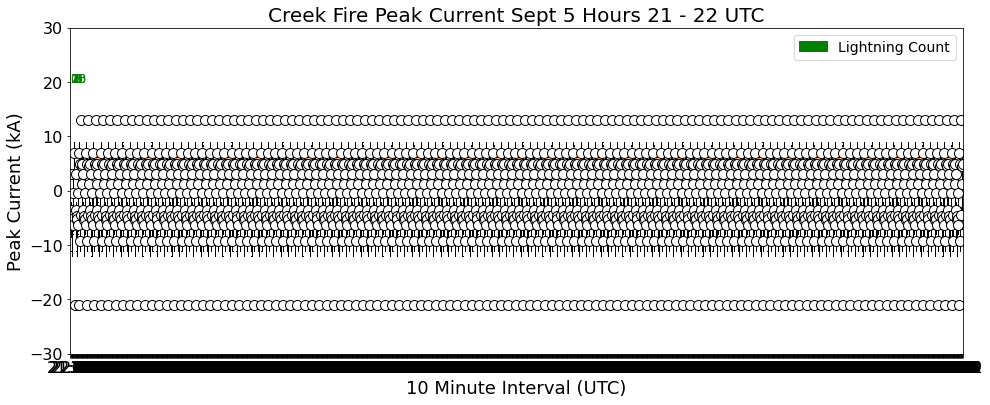

In [46]:

fig, ax = plt.subplots(figsize = (16,6))

ax.set_title('Creek Fire Peak Current Sept 5 Hours 21 - 22 UTC', fontsize = 20)
ax.set_ylabel("Peak Current (kA)", fontsize = 18)
ax.set_xlabel("10 Minute Interval (UTC)", fontsize = 18)


labels = ["21:00",  "", "", "21:30", "", "",
          "22:00",  "", "", "22:30", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)

plt.ylim(-30, 30)

plt.yticks(fontsize = 16)
plt.axhline(y=0,  linestyle='-')

for i in range(0, 12): 
    plt.annotate("{:,}".format(len(strike_array[i])), xy =(i+0.9, 20), fontsize = 12, color = "green")

green_patch = mpatches.Patch(color='green', label='Lightning Count')
plt.legend(handles=[green_patch], fontsize = 14)


ax.boxplot(strike_array, showfliers=False, showmeans = True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})

plt.savefig("boxplot_sept5.png", dpi = 800)
plt.show()



## positive and negative

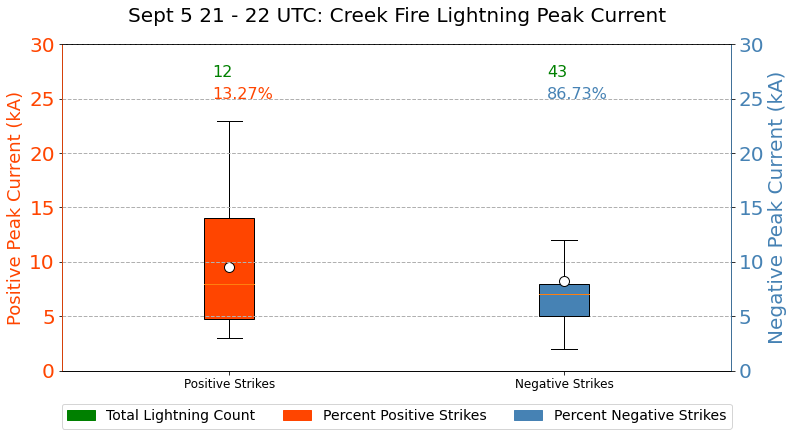

In [47]:
# strike_array_flat 
# strike_pos_array_flat 
# strike_neg_array_flat 

fig, ax = plt.subplots(figsize = (12,6))

ax.set_title('Sept 5 21 - 22 UTC: Creek Fire Lightning Peak Current', fontsize = 20, y = 1.05)
ax.set_ylabel("Positive Peak Current (kA)", color = "orangered", fontsize = 18)
plt.yticks(fontsize = 20)
plt.ylim(0, 30)
plt.yticks(fontsize = 20, color = "orangered")

data = [strike_pos_array_flat] 
box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, positions = [0])

yticks2 = np.arange(0, 30, 10)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
data2 = [list(map(abs, strike_neg_array_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, positions = [1])
ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 30)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['orangered'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Positive Strikes",  "Negative Strikes"]  
ax.set_xticklabels(labels, fontsize = 12)

plt.annotate( "{:,}".format(len(strike_pos_array_flat)), xy =(-0.05, 27), fontsize = 16, color = "green")
plt.annotate("{:,}".format(len(strike_neg_array_flat)), xy =(.95, 27), fontsize = 16, color = "green")

plt.annotate("{:.2f}%".format(np.mean(d["percent_pos_current"][127: 138])), xy =(-0.05, 25), fontsize = 16, color = "orangered")
plt.annotate("{:.2f}%".format(100 - np.mean(d["percent_pos_current"][127: 138])), xy =(.95, 25), fontsize = 16, color = "steelblue")

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='orangered', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='steelblue', label='Percent Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=False)

#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.grid(linestyle='--', linewidth=1)
plt.savefig("boxplot_posneg_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()
